In [1]:
from deepdow.data import InRAMDataset, RigidDataLoader
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
#from deepdow.layers import ConvNetwork
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.benchmarks import OneOverN, InverseVolatility, Random, MinimumVariance
from deepdow.callbacks import EarlyStoppingCallback
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from deepdow.utils import raw_to_Xy
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.experiments import Run
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap

In [ ]:
configs_dict = {
    'task_name': 'long_term_forecast',
    'features': 'M',  # or 'S' for single variable
    'seq_len': 128,
    'label_len': 7,
    'pred_len': 7,
    'use_norm': True,
    'patch_len': 4,
    'enc_in': 35,  # number of input features
    'd_model': 128,  # model dimension
    'embed': 'fixed',  # embedding type
    'freq': 'd',  # frequency of the data
    'dropout': 0.1,
    'factor': 5,  # attention factor
    'n_heads': 8,  # number of attention heads
    'd_ff': 128*4,  # feed-forward dimension
    'e_layers': 3,  # number of encoder layers
    'activation': 'relu',  # activation function
    'augmentation_ratio': 0,  # augmentation ratio
    'seed': 42,  #
}


In [3]:
# 把configs转换为一个类
class Configs:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [4]:
configs = Configs(**configs_dict)

In [5]:
# dataframe from 'mag7_ticker_first.parquet'
# ffill and bfill NaN values in files  'mag7_ticker_first.parquet'
def preprocess_data(df):
    df = df.ffill().bfill()  # forward fill and backward fill NaN values
    return df
# transform columns to returns
def load_data():
    import pandas as pd
    df = pd.read_parquet('mag7_ticker_first.parquet')
    df = preprocess_data(df)
    df = df.pct_change().dropna()  # convert to returns
    return df



In [6]:
from data_provider.data_loader import Dataset_Custom, custom_collate_fn
from torch.utils.data import Dataset, DataLoader
data_path = 'mag7_ticker_first_returns.parquet'
train_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='train',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)
test_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='test',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)

train_dataloader = DataLoader(train_dataset, collate_fn=custom_collate_fn, batch_size=32, shuffle=True)
val_dataloader = DataLoader(test_dataset, collate_fn=custom_collate_fn, batch_size=32, shuffle=True)  

In [7]:
for batch in val_dataloader:
    X_batch, y_batch, timestamps_batch, *kw = batch
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    print("Timestamps:", timestamps_batch)
    #print("kw shape:", [k for k in kw])
    break  # 只打印第一个批次

X shape: torch.Size([32, 5, 128, 7])
y shape: torch.Size([32, 5, 14, 7])
Timestamps: [numpy.datetime64('2024-11-20T00:00:00.000000000'), numpy.datetime64('2024-11-21T00:00:00.000000000'), numpy.datetime64('2024-09-06T00:00:00.000000000'), numpy.datetime64('2024-11-06T00:00:00.000000000'), numpy.datetime64('2025-01-02T00:00:00.000000000'), numpy.datetime64('2024-11-05T00:00:00.000000000'), numpy.datetime64('2024-11-19T00:00:00.000000000'), numpy.datetime64('2025-03-10T00:00:00.000000000'), numpy.datetime64('2025-03-03T00:00:00.000000000'), numpy.datetime64('2024-11-04T00:00:00.000000000'), numpy.datetime64('2025-01-17T00:00:00.000000000'), numpy.datetime64('2025-01-13T00:00:00.000000000'), numpy.datetime64('2025-01-15T00:00:00.000000000'), numpy.datetime64('2024-10-10T00:00:00.000000000'), numpy.datetime64('2025-01-27T00:00:00.000000000'), numpy.datetime64('2025-02-07T00:00:00.000000000'), numpy.datetime64('2025-02-28T00:00:00.000000000'), numpy.datetime64('2024-10-11T00:00:00.000000000

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers.SelfAttention_Family import FullAttention, AttentionLayer
from layers.Embed import DataEmbedding_inverted, PositionalEmbedding
import numpy as np


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class EnEmbedding(nn.Module):
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super(EnEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len

        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)
        self.glb_token = nn.Parameter(torch.randn(1, n_vars, 1, d_model))
        self.position_embedding = PositionalEmbedding(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        glb = self.glb_token.repeat((x.shape[0], 1, 1, 1))

        x = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        x = torch.reshape(x, (-1, n_vars, x.shape[-2], x.shape[-1]))
        x = torch.cat([x, glb], dim=2)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        return self.dropout(x), n_vars


class Encoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        B, L, D = cross.shape
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x_glb_ori = x[:, -1, :].unsqueeze(1)
        x_glb = torch.reshape(x_glb_ori, (B, -1, D))
        x_glb_attn = self.dropout(self.cross_attention(
            x_glb, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])
        x_glb_attn = torch.reshape(x_glb_attn,
                                   (x_glb_attn.shape[0] * x_glb_attn.shape[1], x_glb_attn.shape[2])).unsqueeze(1)
        x_glb = x_glb_ori + x_glb_attn
        x_glb = self.norm2(x_glb)

        y = x = torch.cat([x[:, :-1, :], x_glb], dim=1)

        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Model(nn.Module, Benchmark):

    def __init__(self, configs):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.features = configs.features
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.use_norm = configs.use_norm
        self.patch_len = configs.patch_len
        self.patch_num = int(configs.seq_len // configs.patch_len)
        self.n_vars = 1 if configs.features == 'MS' else configs.enc_in
        # Embedding
        self.en_embedding = EnEmbedding(self.n_vars, configs.d_model, self.patch_len, configs.dropout)

        self.ex_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                   configs.dropout)

        # Encoder-only architecture
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.head_nf = configs.d_model * (self.patch_num + 1)
        self.head = FlattenHead(configs.enc_in, self.head_nf, configs.pred_len,
                                head_dropout=configs.dropout)
        
        # layer to map dec_out to weights shape is        # [batch_size, n_assets]
        self.weight_mapping = nn.Linear(configs.enc_in * configs.pred_len, 7)
        # use softmax allocator to convert weights to allocations
        self.allocator = SoftmaxAllocator()

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape

        en_embed, n_vars = self.en_embedding(x_enc[:, :, -1].unsqueeze(-1).permute(0, 2, 1))
        ex_embed = self.ex_embedding(x_enc[:, :, :-1], x_mark_enc)

        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forecast_multi(self, x_enc, x_mark_enc, x_dec, x_mark_dec): # x_enc: [n_samples, n_channels, seq_len, n_assets] x_mark_enc: [n_samples, n_channels, seq_len, n_assets]
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape

        en_embed, n_vars = self.en_embedding(x_enc.permute(0, 2, 1))
        ex_embed = self.ex_embedding(x_enc, x_mark_enc)

        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        (n_samples, n_channels, lookback, n_assets) = x_enc.shape
        x_enc = x_enc.permute(0, 2, 3, 1).reshape(n_samples, lookback, n_assets * n_channels)
        (n_samples, lookback, n_mark) = x_mark_enc.shape
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            if self.features == 'M':
                dec_out = self.forecast_multi(x_enc, x_mark_enc, x_dec, x_mark_dec)
                weight_out = self.weight_mapping(dec_out[:, -self.pred_len:, :].reshape(n_samples, -1))  # [B, L, D] -> [B, L * D]
                #return dec_out[:, -self.pred_len:, :]  # [B, L, D]
                weights = self.allocator(weight_out)  # [B, L, D] -> [B, L, D]
                return weights, dec_out
            else:
                dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        else:
            return None

In [9]:
network = Model(configs)

In [10]:
from deepdow.losses import Loss
from types import MethodType
class CustomLoss(Loss):
    """Custom Loss class that extends the Loss class.

    The __call__ method accepts additional parameters.
    """

    def _call(self, weights, y, *extra):
        raise NotImplementedError()

    def __repr__(self):
        """Generate representation string."""
        return self._repr()

    def __call__(self, weights, y, *extra):
        """Compute loss including extra parameters."""
        return self._call(weights, y, *extra)

    def __add__(self, other):
        """Add two losses together (supports Loss and CustomLoss)."""
        if isinstance(other, Loss):
            new_instance = CustomLoss()
            new_instance._call = MethodType(
                lambda inst, weights, y, *extra: self(weights, y, *extra) + other(weights, y),
                new_instance,
            )
            new_instance._repr = MethodType(
                lambda inst: "{} + {}".format(self.__repr__(), other.__repr__()),
                new_instance,
            )
            return new_instance
        elif isinstance(other, (int, float)):
            new_instance = CustomLoss()
            new_instance._call = MethodType(
                lambda inst, weights, y, *extra: self(weights, y, *extra) + other, new_instance
            )
            new_instance._repr = MethodType(
                lambda inst: "{} + {}".format(self.__repr__(), other),
                new_instance,
            )
            return new_instance
        else:
            raise TypeError("Unsupported type: {}".format(type(other)))

    def __mul__(self, other):
        """Multiply two losses together."""
        if isinstance(other, Loss):
            new_instance = CustomLoss()
            new_instance._call = MethodType(
                lambda inst, weights, y, *extra: self(weights, y, *extra) * other(weights, y),
                new_instance,
            )
            new_instance._repr = MethodType(
                lambda inst: "{} * {}".format(self.__repr__(), other.__repr__()),
                new_instance,
            )
            return new_instance
        elif isinstance(other, (int, float)):
            new_instance = CustomLoss()
            new_instance._call = MethodType(
                lambda inst, weights, y, *extra: self(weights, y, *extra) * other, new_instance
            )
            new_instance._repr = MethodType(
                lambda inst: "{} * {}".format(self.__repr__(), other),
                new_instance,
            )
            return new_instance
        else:
            raise TypeError("Unsupported type: {}".format(type(other)))

In [11]:
class MyLoss(CustomLoss):
    """Custom loss that computes the mean squared error between weights and returns."""

    def _call(self, weights, y, *extra):
        # Assuming y is the returns
        return torch.mean((weights - y) ** 2)

    def __repr__(self):
        return "MyLoss()"

In [12]:
my_loss = MyLoss()
my_loss(torch.tensor([[0.1, 0.2], [0.3, 0.4]]), torch.tensor([[0.1, 0.2], [0.3, 0.5]])) + my_loss(torch.tensor([[0.1, 0.2], [0.3, 0.4]]), torch.tensor([[0.1, 0.2], [0.3, 0.5]]))

tensor(0.0050)

In [13]:
loss = MaximumDrawdown(input_type='simple') + MeanReturns(input_type='simple') + 3 * SharpeRatio(input_type='simple', rf=0.000) #+ my_loss

In [14]:
def mse_loss(y_pred, y_true):
    """
    Calculate Mean Squared Error (MSE) loss.
    
    Args:
        y_pred (torch.tensor): Predicted values, shape (batch_size, pred_len, n_assets)
        y_true (torch.tensor): True values, shape (batch_size, pred_len, n_assets)
    
    Returns:
        float: MSE loss
    """
    squared_diff = (y_pred - y_true) ** 2
    mse = torch.mean(squared_diff)
    return mse

In [15]:
import time
from deepdow.experiments import Run, SolverError, EarlyStoppingException
from numpy import NaN

class ExtendedRun(Run):
    def launch(self, n_epochs=1):
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, batch in enumerate(self.train_dataloader):
                    # 解包以支持额外变量
                    X_batch, y_batch, timestamps, asset_names, *extra = batch
                    extra_data = extra[0] if extra else None  # 处理无额外数据的情况

                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                    X_batch, y_batch = X_batch.to(self.device).to(self.dtype), y_batch.to(self.device).to(self.dtype)
                    extra = [d.to(self.device).to(self.dtype) if isinstance(d, torch.Tensor) else d for d in extra]

                    # if extra_data is not None:
                    #     extra_data = extra_data.to(self.device).to(self.dtype)

                    self.network.train()
                    
                    X_mark = extra[0]
                    y_mark = extra[1] if len(extra) > 1 else None
                    weights, y_pred = self.network(X_batch, X_mark, y_batch, y_mark)
                    
                    y_true = y_batch[:,0,:,:]
                    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 7, -1)[:,:,:,0]  # [batch_size, pred_len, n_assets]
                    # 如果支持，将 extra_data 传递给损失函数
                    y_true = y_true[:, -configs.pred_len:, :]
                    loss_2 = mse_loss(y_pred, y_true)
                    loss_per_sample = self.loss(weights, y_batch) 
                    loss = loss_per_sample.mean() + 2*loss_2
                    if torch.isnan(loss):
                        print("NaN loss encountered. Skipping this batch.")
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    self.network.eval()

                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("训练中断")
            time.sleep(1)
            self.on_train_interrupt(metadata={"exception": ex, "locals": locals()})

        return self.history

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = configs.d_model
n_heads = configs.n_heads
n_layers = configs.e_layers

In [17]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = ExtendedRun(network,
          loss,
          train_dataloader,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'test': val_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15),
                     ModelCheckpointCallback(folder_path=f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/',
                                             dataloader_name='test',
                                             metric_name='loss')],
          device=device,
          #dtype=torch.float64,
          )

#

In [31]:
history = run.launch(15)

Epoch 22: 100%|██████████| 101/101 [00:06<00:00, 15.44it/s, loss=-0.66261, test_loss=-0.19144]


训练中断
Training stopped early because there was no improvement in test_loss for 15 epochs


In [19]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       137
                    OneOverN       -1       137
                    network         0       137
                                    1       137
                                    2       137
                                    3       137
                                    4       137
                                    5       137
                                    6       137
                                    7       137
                                    8       137
                                    9       137
                                    10      137
                                    11      137
                                    12      137
                                    13      137
                                    14      137
Name: value, dtype: int64
dataloader  metric  model          epoch
test        loss    MaximumReturn  -1       0.020
                    OneOve

<Axes: xlabel='epoch'>

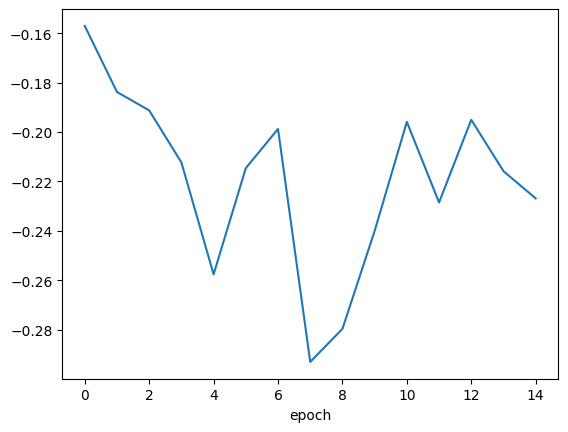

In [20]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [21]:
from json import load
import os

model_path = f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/'
#获得model_path下日期最新的文件
best_model_file = model_path + sorted(os.listdir(model_path), key=lambda x: os.path.getmtime(os.path.join(model_path, x)), reverse=True)[0]
print(f'best model file: {best_model_file}')

loaded_network = torch.load(best_model_file, weights_only=False)
loaded_network.eval()

best model file: ./models/2025-06-04 15-52-01_d_model_128_nhead8_num_layers3/model_07__-0.2931.pth


Model(
  (en_embedding): EnEmbedding(
    (value_embedding): Linear(in_features=12, out_features=128, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ex_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection): Linear(in_features=128, out_features=128, bias=True)
          (value_projection): Linear(in_features=128, out_features=128, bias=True)
          (out_projection): Linear(in_features=128, out_features=128, bias=True)
        )
        (cross_attention): AttentionLayer(
          (

In [22]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    #'network': network,
    'best_network': loaded_network
}

In [23]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [24]:
metrics_table = generate_metrics_table(benchmarks,
                                       val_dataloader,
                                       metrics,
                                       device='cuda')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

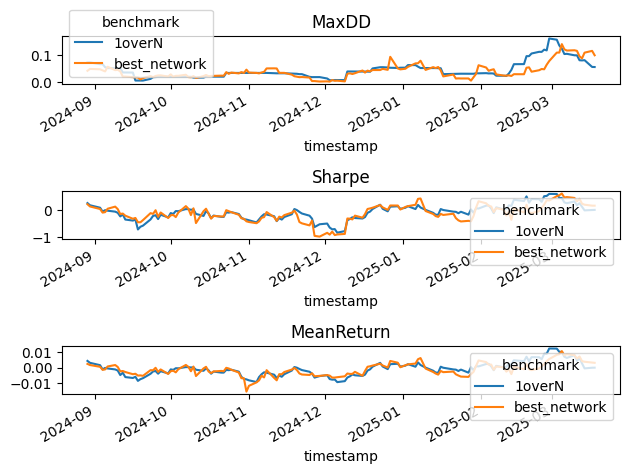

In [25]:
plot_metrics(metrics_table)

In [26]:
weight_table = generate_weights_table(network, val_dataloader,device = device)

<Axes: >

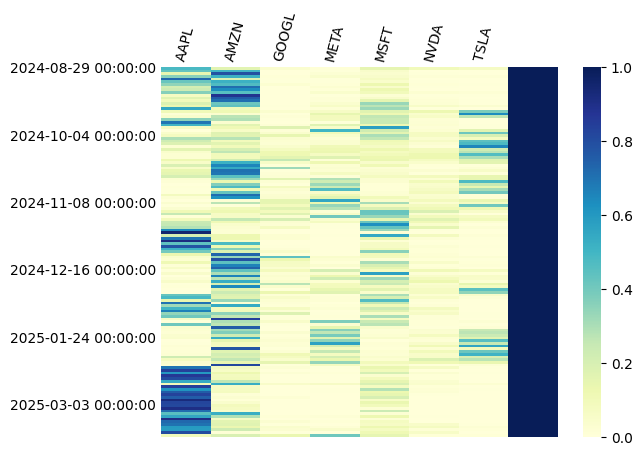

In [27]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [28]:
import torch
y = torch.load('/home/userroot/dev/deep_portfolio/sft/y_tmp.pt')
weights = torch.load('/home/userroot/dev/deep_portfolio/sft/weights_tmp.pt')  

In [29]:
loss = MaximumDrawdown(input_type='simple')

In [30]:
loss(weights, y)  # 计算损失

tensor([0.0599, 0.8670, 0.2048, 0.5518, 0.0521, 0.2314, 0.9429, 0.0756, 0.0904,
           nan, 0.2528, 0.1514, 0.1212, 0.1634, 0.1340, 0.1593, 0.1352, 0.9653,
           nan, 0.2110, 0.1961, 0.2028,    nan, 0.1306, 0.5965, 0.0925, 0.6614,
        0.1517, 0.2000, 0.1453, 0.2203, 0.0173], device='cuda:0',
       grad_fn=<NegBackward0>)